In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import healpy as hp
import matplotlib.pylab as pl

# Load some spherical data 

Let us load two maps with the same PSD and different high order statistics.

In [3]:
img1 = hp.read_map('data_v4/kappa_omega_m_0p3.fits')
img2 = hp.read_map('data_v4/kappa_omega_m_0p26.fits')
img1 = hp.reorder(img1,r2n=True)
img2 = hp.reorder(img2,r2n=True)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


Down sampling of the maps

In [ ]:
Nside = 1024
img1 = hp.ud_grade(img1,nside_out=Nside, order_in='NESTED')
img2 = hp.ud_grade(img2,nside_out=Nside, order_in='NESTED')

Let us display the two maps

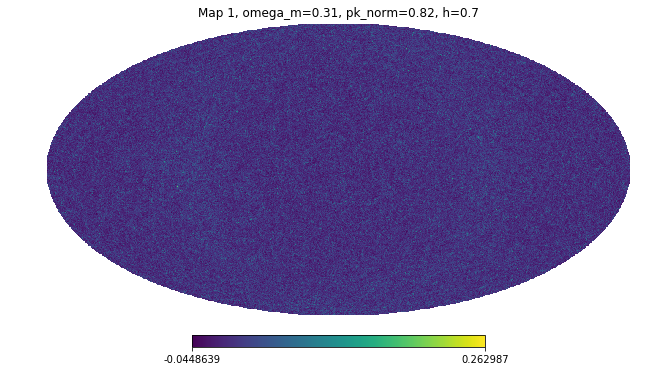

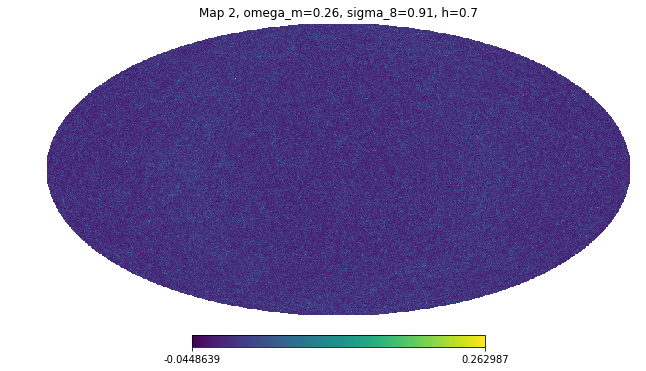

In [5]:
cmin = min(np.min(img1), np.min(img2))
cmax = max(np.max(img1), np.max(img2))
hp.mollview(img1, title='Map 1, omega_m=0.31, pk_norm=0.82, h=0.7', nest=True, min=cmin ,max=cmax)
hp.mollview(img2, title='Map 2, omega_m=0.26, sigma_8=0.91, h=0.7', nest=True, min=cmin ,max=cmax)

Let us cut the sphere into 192 smaller subparts. We display 16 of them bellow.

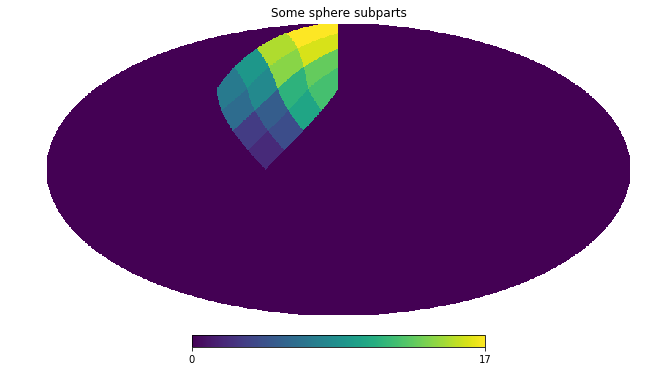

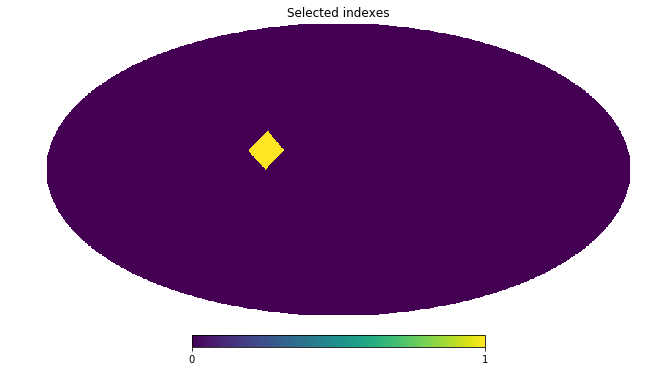

In [6]:
order = 4

index = np.array(list(range(hp.nside2npix(order))))+2
mask = np.zeros(index.shape,dtype=np.int)
mask[:order**2] = 1
index  *= mask
hp.mollview(index, title='Some sphere subparts', nest=True)

marker = np.zeros(hp.nside2npix(order))
marker[0] = 1
hp.mollview(marker, title='Selected indexes', nest=True)

## Split the data

In [7]:
def hp_split(img, order, nest=True):
    ''' This function split the data of different part of the sphere. 
        Return the splitted data and some possible index on the sphere
    '''
    npix = len(img)
    nside = hp.npix2nside(npix)
    if hp.nside2order(nside) < nside:
        ValueError('Order not compatible with data')
    if not nest:
        NotImplementedError('Implement the change of coordidinate')
    nsample = 12 * (order**2)
    return img.reshape([nsample,npix//nsample]), np.array(list(range(npix//nsample)))
    

In [8]:
data = dict()
data['class1'], _ = hp_split(img1, order=4)
data['class2'], index = hp_split(img2, order=4)

In [9]:
print('The data is of shape {}'.format(data['class1'].shape))

The data is of shape (192, 65536)


Let us diplay one data sample on the entire sphere.

In [22]:
# npix = hp.nside2npix(nside)
# mask = np.ones([npix])>0
# mask[index] = False
# hp.ma()
imgt = img1.copy()
imgt[data['class1'].shape[1]:]=hp.UNSEEN
imgt = hp.ma(imgt)

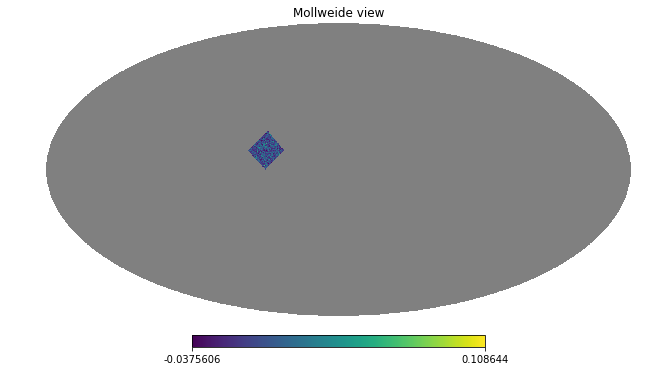

In [23]:
projected_map = hp.mollview(imgt,nest=True, return_projected_map = True, xsize = 1600 )

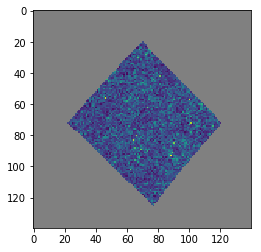

In [25]:
plt.imshow(projected_map[380:520, 530:670])

# Preparing data for the classifier
Let us split the data into training and testing sets. The raw data is stored into `x_raw` and the histograms into `x_trans`. As a transformation, we cannot use the power spectrum density. Hence we do an histogram of the data.

In [26]:
def trans(x,cmin,cmax):
    if len(x.shape)>1:
        d = []
        for el in x:
            y,_ = np.histogram(el, bins=100, range=[cmin,cmax])
            d.append(y.astype(float))
        return np.array(d)
    else:
        y,_ = np.histogram(x, bins=100, range=[cmin,cmax])
        return y.astype(float)


In [27]:
from sklearn import preprocessing


# Put all the data in a single matrix
x_raw = np.vstack((data['class1'],data['class2']))
x_raw = x_raw / np.mean(x_raw*x_raw) # Apply some normalization (We do not want to affect the mean)
cmin = np.min(x_raw)
cmax = np.max(x_raw)
x_trans = trans(x_raw, cmin, cmax)
x_trans = preprocessing.scale(x_trans)



# Create the label vector
labels = np.zeros([x_raw.shape[0]])
labels[len(data['class1']):] = 1
labels = labels.astype(np.int)

# Random reordering
p = np.random.permutation(len(labels))
x_raw = x_raw[p,]
x_trans = x_trans[p,]
labels = labels[p]

ntrain = 300
ntest = len(x_raw) - ntrain
x_raw_train = x_raw[:ntrain]
x_trans_train = x_trans[:ntrain]
labels_train = labels[:ntrain]
x_raw_test = x_raw[ntrain:]
x_trans_test = x_trans[ntrain:]
labels_test = labels[ntrain:]

print('Class 1 VS class 2 \n  Training set: {} / {}\n  Testing set: {} / {}'.format(
    ntrain-sum(labels_train), sum(labels_train), ntest-sum(labels_test), sum(labels_test) ))

Class 1 VS class 2 
  Training set: 155 / 145
  Testing set: 37 / 47


# Classification using SVM
Let us test classify our data using an SVM classifier

While running an SVM classifier on the data will fail because of their dimensionality, we observe that we can correctly classify our dataset using the histogram.

Make with an histogram

In [73]:
from sklearn.svm import SVC

clf_raw = SVC(kernel='rbf')
clf_raw.fit(x_raw_train, labels_train) 

print('Errors on training: {}%'.format(
    sum(np.abs(clf_raw.predict(x_raw_train)-labels_train))/ntrain*100))
print('Errors on testing: {}%'.format(
    sum(np.abs(clf_raw.predict(x_raw_test)-labels_test))/ntest*100))

Errors on training: 0.0%
Errors on testing: 53.57142857142857%


In [28]:
from sklearn.svm import SVC


clf_raw = SVC(kernel='rbf')
clf_raw.fit(x_trans_train, labels_train) 

print('Errors on training: {}%'.format(
    sum(np.abs(clf_raw.predict(x_trans_train)-labels_train))/ntrain*100))
print('Errors on testing: {}%'.format(
    sum(np.abs(clf_raw.predict(x_trans_test)-labels_test))/ntest*100))

Errors on training: 0.0%
Errors on testing: 0.0%


# Plot the histogram features
Let us first plot the mean and then each feature individually

Text(0.5,1,'Individual samples')

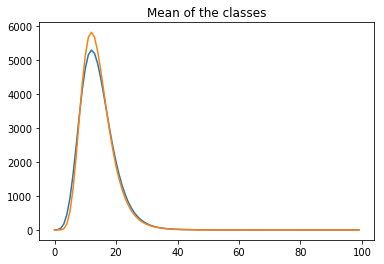

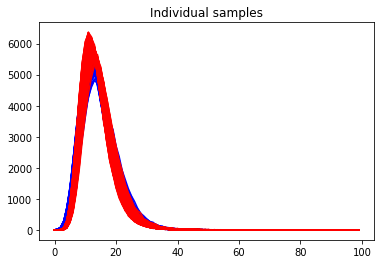

In [16]:
# plot(np.mean(trans(data['class1'], cmin, cmax),axis=0))
# plot(np.mean(trans(data['class2'], cmin, cmax),axis=0))
x_trans = trans(x_raw, cmin, cmax)
fig = plt.figure()
plot(np.mean(x_trans[labels==0],axis=0))
plot(np.mean(x_trans[labels==1],axis=0))
title('Mean of the classes')
fig = plt.figure()
plot(x_trans[labels==0].T, 'b')
plot(x_trans[labels==1].T, 'r')
_, title('Individual samples')

# Classification using a spherical CNN
Let us now classify our data using a spherical convolutional neural network.

In [17]:
from scnn import models

In [18]:
nsides = [Nside, Nside, Nside//2, min(Nside//8, 128)]
# nsides = [2048, 1024, 256, 64]
# nsides = [128, 32, 16]

indexes = []
nsample = 12 * (order**2)
for nside in nsides:
    indexes.append(np.array(list(range(hp.nside2npix(nside)//nsample))))


In [40]:
C = 2 # number of class

params = dict()
params['dir_name']       = 'test'
params['num_epochs']     = 10
params['batch_size']     = 20
params['eval_frequency'] = 10

# Building blocks.
params['brelu']          = 'b1lrelu' # Relu 
params['pool']           = 'apool1' # Average pooling

# Architecture.
params['nsides']         = nsides # Sizes of the laplacians are nsides * nisides * 12
params['indexes']        = indexes # Sizes of the laplacians are nsides * nisides * 12
params['F']              = [5, 10, 10, 10]  # Number of graph convolutional filters.
params['K']              = [10, 10, 10, 10]  # Polynomial orders.
params['batch_norm']     = [True, True, True, True]  # Batch norm
params['M']              = [100, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 2e-4
params['dropout']        = 0.8
params['learning_rate']  = 10e-4
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['adam']           = True
params['decay_steps']    = ntrain / params['batch_size']

In [41]:
model = models.scnn(**params)

NN architecture
  input: M_0 = 65536
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 65536 * 5 / 1 = 327680
    weights: F_0 * F_1 * K_1 = 1 * 5 * 10 = 50
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 65536 * 10 / 4 = 163840
    weights: F_1 * F_2 * K_2 = 5 * 10 * 10 = 500
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 16384 * 10 / 16 = 10240
    weights: F_2 * F_3 * K_3 = 10 * 10 * 10 = 1000
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 1024 * 10 / 1 = 10240
    weights: F_3 * F_4 * K_4 = 10 * 10 * 10 = 1000
  layer 5: fc1
    representation: M_5 = 100
    weights: M_4 * M_5 = 10240 * 100 = 1024000
    biases: M_5 = 100
  layer 6: logits (softmax)
    representation: M_6 = 2
    weights: M_5 * M_6 = 100 * 2 = 200
    biases: M_6 = 2


In [42]:
accuracy, loss, t_step = model.fit(x_raw_train, labels_train, x_raw_test, labels_test)

step 10 / 150 (epoch 0.67 / 10):
  learning_rate = 9.50e-04, loss_average = 1.04e+00
  validation accuracy: 82.14 (69 / 84), f1 (weighted): 82.04, loss: 1.19e+01
  time: 883s (wall 97s)
step 20 / 150 (epoch 1.33 / 10):
  learning_rate = 9.03e-04, loss_average = 1.01e+00
  validation accuracy: 97.62 (82 / 84), f1 (weighted): 97.62, loss: 1.23e+01
  time: 1814s (wall 197s)
step 30 / 150 (epoch 2.00 / 10):
  learning_rate = 8.57e-04, loss_average = 8.19e-01
  validation accuracy: 97.62 (82 / 84), f1 (weighted): 97.62, loss: 1.24e+01
  time: 2741s (wall 295s)
step 40 / 150 (epoch 2.67 / 10):
  learning_rate = 7.74e-04, loss_average = 7.73e-01
  validation accuracy: 95.24 (80 / 84), f1 (weighted): 95.25, loss: 1.26e+01
  time: 3671s (wall 394s)
step 50 / 150 (epoch 3.33 / 10):
  learning_rate = 7.35e-04, loss_average = 7.61e-01
  validation accuracy: 95.24 (80 / 84), f1 (weighted): 95.25, loss: 1.26e+01
  time: 4602s (wall 492s)
step 60 / 150 (epoch 4.00 / 10):
  learning_rate = 6.98e-04, l

In [ ]:
print('Errors on training: {}%'.format(
    sum(np.abs(model.predict(x_raw_train)-labels_train))/ntrain*100))
print('Errors on testing: {}%'.format(
    sum(np.abs(model.predict(x_raw_test)-labels_test))/ntest*100))

## Comments about the results
Without subsampling
I train the spherical CNN a few minutes on CPU and I obtain 96% validation accuracy. 

SVM is consistenly failling with the raw data but succeed with the histograms.

Conclusion: the spherical CNN is able to discriminate over data with the same mean and same PSD using only 192th of the sphere.

Effect of subsampling
 - N=512, errors on training/testing: 11.66%, 78.57% => complete fail
 - N=1024, errors on training/testing: 0%, 0-3% => partial success
 - N=2048, errors on training/testing: 0%, 3% => partial success

Maybe this is also due to the fact that the training/validation sets are not the same for each run.
    

## Some other plotting

In [ ]:
# from scnn import utils
# nside_v = 32
# nsample = 12 * (order**2)
# ind = np.array(list(range(hp.nside2npix(nside_v)//nsample)))
# G = utils.healpix_graph(nside=nside_v, nest=True, indexes=ind)

# G.plot()
